In [6]:
import numpy as np 
import pandas as pd

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error as mae

from umap import UMAP

import optuna
import catboost as cb

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Input

seed = 228
np.random.seed(seed)
tf.random.set_seed(seed)


In [15]:
train = pd.read_csv(r'C:\\Users\\Hamdi\\Desktop\\New folder (2)\\train\\train.csv')
test = pd.read_csv(r'C:\\Users\\Hamdi\\Desktop\\New folder (2)\\test\\Synthetic data\\test.csv')
ss = pd.read_csv(r'C:\Users\Hamdi\Desktop\New folder (2)\submission.csv')

orig_train = pd.read_csv(r'C:\Users\Hamdi\Desktop\New folder (2)\train\healthcare-dataset-stroke-data.csv')
train.drop('id', axis=1, inplace=True)
orig_train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [16]:
# Show all columns
pd.set_option('display.max_columns', None)

# Bold font
bold = ['\033[1m', '\033[0m']

In [17]:
num_cols = test.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('hypertension') # in fact, this is a categorical feature
num_cols.remove('heart_disease') # and this is too
cat_cols = list(set(test.columns) - set(num_cols))
df = orig_train.copy()

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    
cols = ['age', 'ever_married', 'work_type', 
        'smoking_status', 'avg_glucose_level', 
        'hypertension', 'heart_disease']
knn = KNeighborsRegressor(n_neighbors=100,
                          metric='minkowski',
                          n_jobs=-1)
knn.fit(df[cols], df.index)
dists, nears = knn.kneighbors(df[cols], return_distance=True)

# Check results
result = []
for i, n in enumerate(nears):
    n = list(n)
    n.remove(i)
    try:
        avg_bmi = df.iloc[n]['bmi'].median()
        result.append(mae(np.array([df.iloc[i]['bmi']]), 
                          np.array([avg_bmi])))
    except:
        continue
        
print(f'MAE mean score: {round(np.mean(result), 2)}')
print(f'MAE median score: {round(np.median(result), 2)}')

# Restore missing values
result = []
for i in df.query('bmi!=bmi').index:
    result.append(round(df.iloc[nears[i]]['bmi'].median(),1))
df.loc[orig_train.query('bmi!=bmi').index, 'bmi'] = result
orig_train['bmi'] = df['bmi']

MAE mean score: 4.91
MAE median score: 3.65


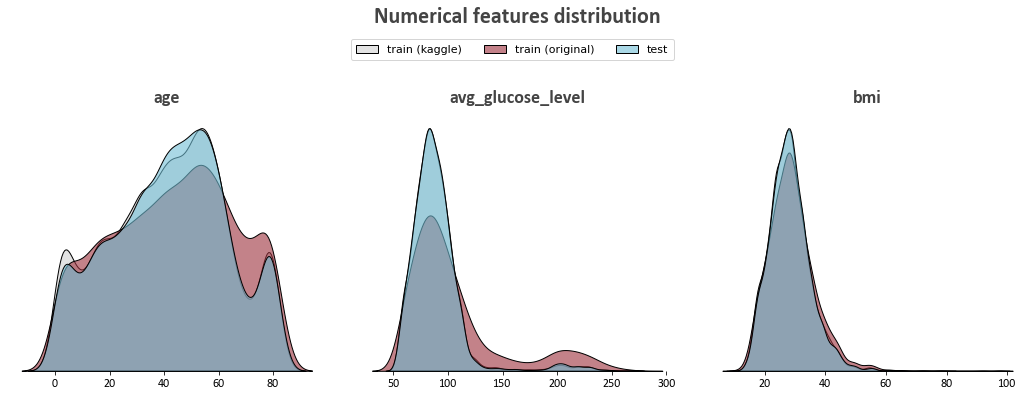

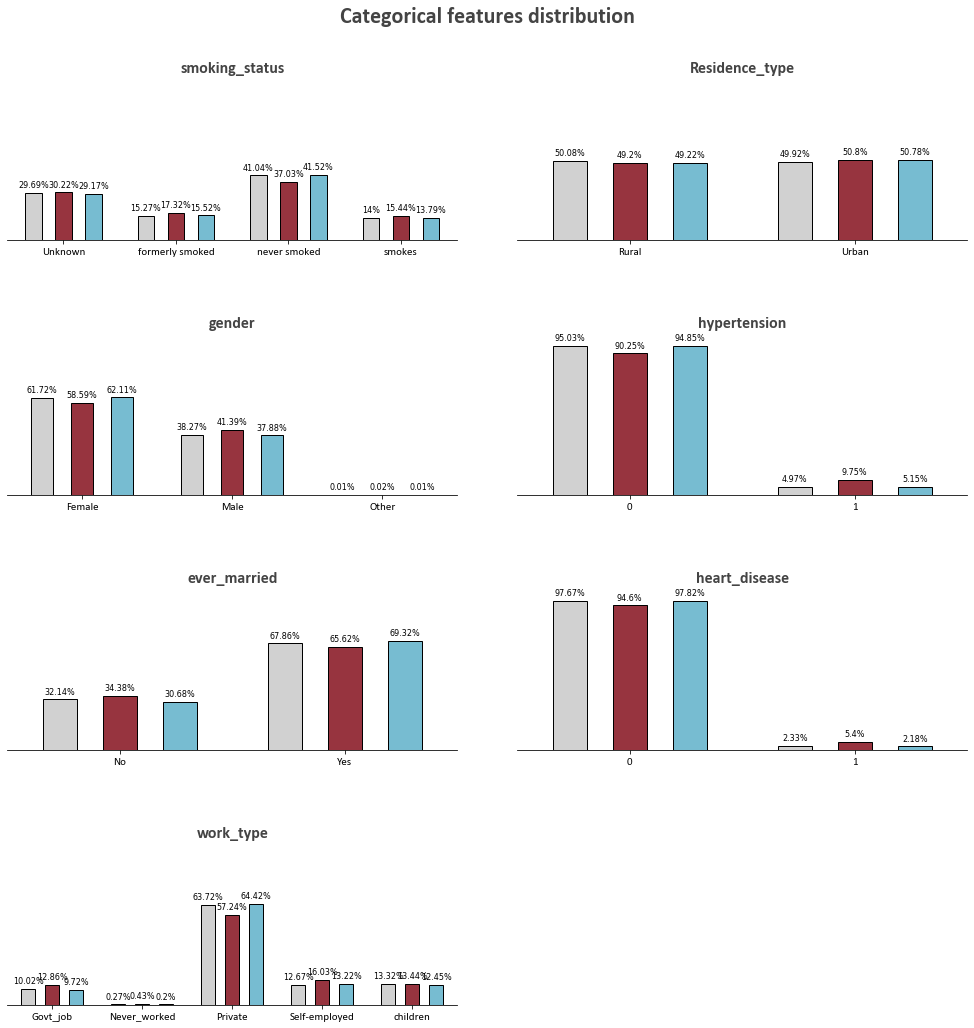

In [18]:
fig = plt.figure(figsize = (15, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1,3,i+1)
    plt.title(col, size=18, y=1.03, fontname='Calibri', 
              fontweight='bold', color='#444444')
    a = sns.kdeplot(train[col], color='#d1d1d1', 
                    shade=True, label='train kaggle', 
                    alpha=0.6, edgecolor='black')
    sns.kdeplot(orig_train[col], color='#9c2f3b', 
                shade=True, label='train original', 
                alpha=0.6, edgecolor='black')
    sns.kdeplot(test[col], color='#72bfd6', 
                shade=True, label='test', 
                alpha=0.6, edgecolor='black')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname='Calibri', size=12)
    plt.yticks([])
    for s in ['right', 'top', 'left', 'bottom']:
        a.spines[s].set_visible(False)
        
fig.tight_layout(pad=3)
fig.legend(['train (kaggle)', 'train (original)', 'test'], bbox_to_anchor=(0.65, 1.07), 
           ncol=3, borderpad=0.5, frameon=True, fontsize=11, title_fontsize=12)
plt.figtext(0.5, 1.1, 'Numerical features distribution', 
            fontname='Calibri', fontweight='bold',
            size=22, color='#444444', ha='center') 
plt.show()

###########################################

print()
print()
cat_cols = list(set(test.columns) - set(num_cols))

train['data'] = 'kaggle'
orig_train['data'] = 'original'
test['data'] = 'test'
df = pd.concat([train, orig_train, test])

l = {'kaggle': len(train), 'original': len(orig_train), 'test': len(test)}

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

fig = plt.figure(figsize=(15, 15))
for i, col in enumerate(cat_cols):
    df_plot = df.groupby(['data', col], as_index=False) \
                  ['age'].count().rename({'age': 'count'}, axis=1)
    df_plot['len_data'] = df_plot['data'].apply(lambda x: l[x])
    df_plot['count'] = round(df_plot['count'] / df_plot['len_data'] * 100, 2)
    
    plt.subplot(4,2,i+1)
    plt.title(col, size=16, y=1.03, fontname='Calibri', 
              fontweight='bold', color='#444444')
    a = sns.barplot(data=df_plot, x=col, y='count', hue='data',
                    palette=['#d1d1d1', '#9c2f3b', '#72bfd6'], 
                    linestyle="-", linewidth=1, edgecolor="black", 
                    saturation=0.9)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname='Calibri', size=11)
    a.set_yticks([0, 100])
    plt.yticks([])

    for p in a.patches:
        height = p.get_height()
        a.annotate(f'{height:g}%', (p.get_x() + p.get_width() / 2, p.get_height()+2), 
                   ha='center', va='center', size=8,xytext=(0, 5), 
                   textcoords='offset points')
    
    for s in ['right', 'top', 'left']:
        a.spines[s].set_visible(False)

    a.legend().set_visible(False)
    change_width(a, 0.15)

fig.tight_layout(pad=6)
plt.figtext(0.5, 0.98, 'Categorical features distribution', 
            fontname='Calibri', fontweight='bold',
            size=22, color='#444444', ha='center') 
plt.show()

In [19]:
fig = make_subplots(rows=1, cols=2, 
                    vertical_spacing=0.1,
                    specs=[[{"type": "pie"}, {"type": "pie"}]],
                    subplot_titles=('<b>Kaggle</b>',  
                                    '<b>Original</b>'))
for i, df in enumerate([train, orig_train]):
    info = df['stroke'].value_counts().reset_index()
    info['index'] = info['index'].map({0: 'No', 1: 'Yes'})
    fig.add_trace(go.Pie(labels=info['index'],
                         values=info['stroke'],
                         textinfo='label+percent',
                         textposition = 'inside',
                         hoverinfo='value',
                         textfont_size=22,
                         marker=dict(colors=['#72bfd6', '#9c2f3b'],
                                     line=dict(color='#444444', width=1)),
                         hole=0.75,
                         showlegend=False),
                  row=1, col=i+1)
    
fig.update_layout(width=750, height=450, plot_bgcolor='white',
                  font_family="Calibri", font_color="#444444",
                  hoverlabel=dict(font_size=14, font_family="Calibri"))

fig.layout.annotations[0].update(x=0.225, y=0.46, font_size=24)
fig.layout.annotations[1].update(x=0.775, y=0.46, font_size=24)

fig.show()

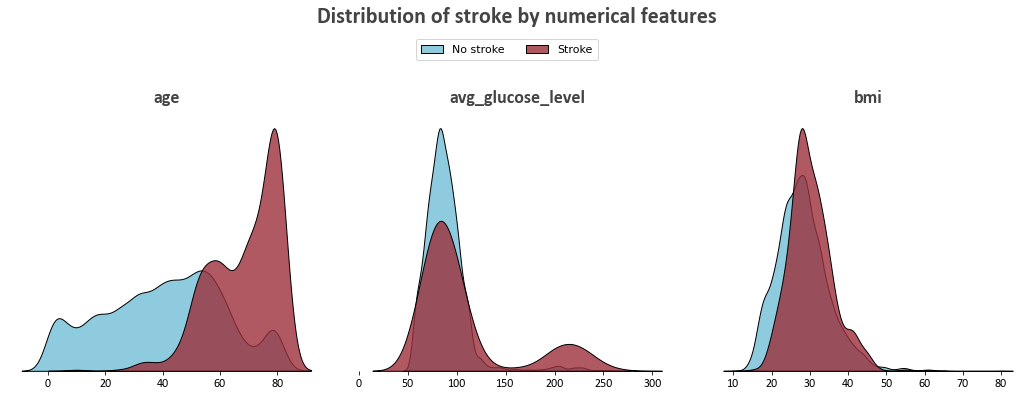

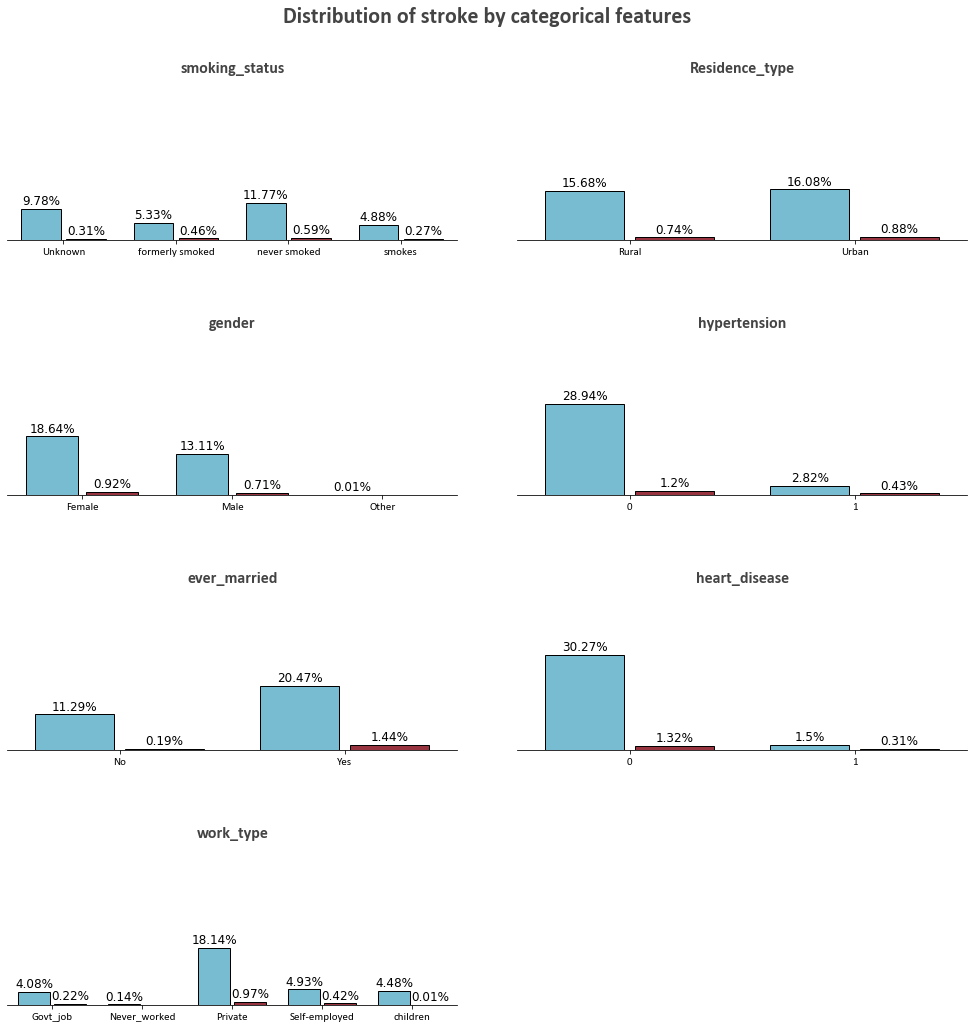

In [20]:
fig = plt.figure(figsize = (15, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1,3,i+1)
    plt.title(col, size=18, y=1.03, fontname='Calibri', 
              fontweight='bold', color='#444444')
    a = sns.kdeplot(train[train['stroke']==0][col], 
                    color='#72bfd6', label='No stroke', 
                    shade=True, alpha=0.8, edgecolor='black')
    sns.kdeplot(train[train['stroke']==1][col], color='#9c2f3b', 
                shade=True, label='Stroke', 
                alpha=0.8, edgecolor='black')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname='Calibri', size=12)
    plt.yticks([])
    for s in ['right', 'top', 'left', 'bottom']:
        a.spines[s].set_visible(False)
        
fig.tight_layout(pad=3)
fig.legend(['No stroke', 'Stroke'], bbox_to_anchor=(0.58, 1.07), 
           ncol=2, borderpad=0.5, frameon=True, fontsize=11, title_fontsize=12)
plt.figtext(0.5, 1.1, 'Distribution of stroke by numerical features', 
            fontname='Calibri', fontweight='bold',
            size=22, color='#444444', ha='center') 
plt.show()

###########################################

print()
print()

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

fig = plt.figure(figsize=(15, 15))
for i, col in enumerate(cat_cols):
    df_plot = df.groupby(['stroke', col], as_index=False) \
                  ['age'].count().rename({'age': 'count'}, axis=1)
    df_plot['count'] = round(df_plot['count'] / len(train) * 100, 2)
    
    plt.subplot(4,2,i+1)
    plt.title(col, size=16, y=1.03, fontname='Calibri', 
              fontweight='bold', color='#444444')
    a = sns.barplot(data=df_plot, x=col, y='count', hue='stroke',
                    palette=['#72bfd6', '#9c2f3b'], 
                    linestyle="-", linewidth=1, edgecolor="black", 
                    saturation=0.9)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname='Calibri', size=11)
    a.set_yticks([0, 50])
    plt.yticks([])

    for p in a.patches:
        height = p.get_height()
        a.annotate(f'{height:g}%', (p.get_x() + p.get_width() / 2, p.get_height()+1), 
                   ha='center', va='center', size=12, xytext=(0, 5), 
                   textcoords='offset points')
    
    for s in ['right', 'top', 'left']:
        a.spines[s].set_visible(False)

    a.legend().set_visible(False)
    change_width(a, 0.35)

fig.tight_layout(pad=6)
plt.figtext(0.5, 0.98, 'Distribution of stroke by categorical features', 
            fontname='Calibri', fontweight='bold',
            size=22, color='#444444', ha='center') 
plt.show()


In [21]:
orig_train = orig_train[orig_train['stroke']==1]
train = pd.concat([orig_train, train], ignore_index=True)
train.drop('data', axis=1, inplace=True) # This column was created to build a barplot
test.drop('data', axis=1, inplace=True)
df = train.copy()

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

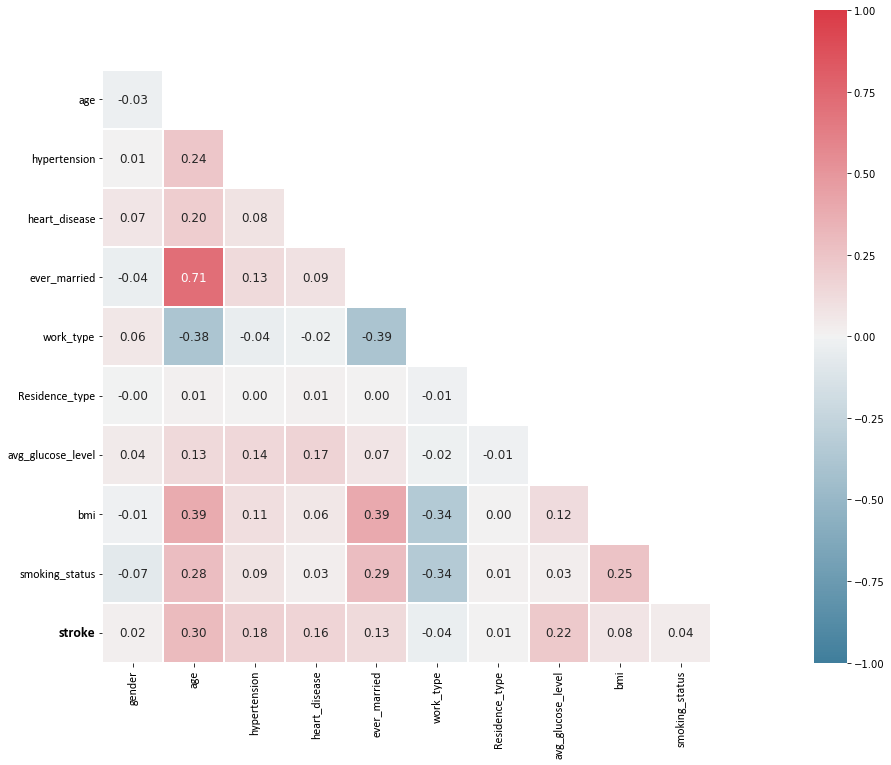

In [22]:
matrix = np.triu(df.corr())
plt.figure(figsize = (15, 12))
a = sns.heatmap(df.corr(), mask=matrix, annot=True, annot_kws={'fontsize': 12}, 
            cmap=sns.diverging_palette(230, 10, as_cmap=True), cbar=True,
            vmin=-1, vmax=1, fmt='.2f', linewidths=0.1, linecolor='white')
plt.xticks(size=12, fontname='Calibri')
plt.yticks(size=12, fontname='Calibri')
a.set_xticks(a.get_xticks()[:-1])
a.set_yticks(a.get_yticks()[1:])
plt.yticks()[-1][-1].set_fontsize(14)
plt.yticks()[-1][-1].set_fontweight('bold')
plt.show()

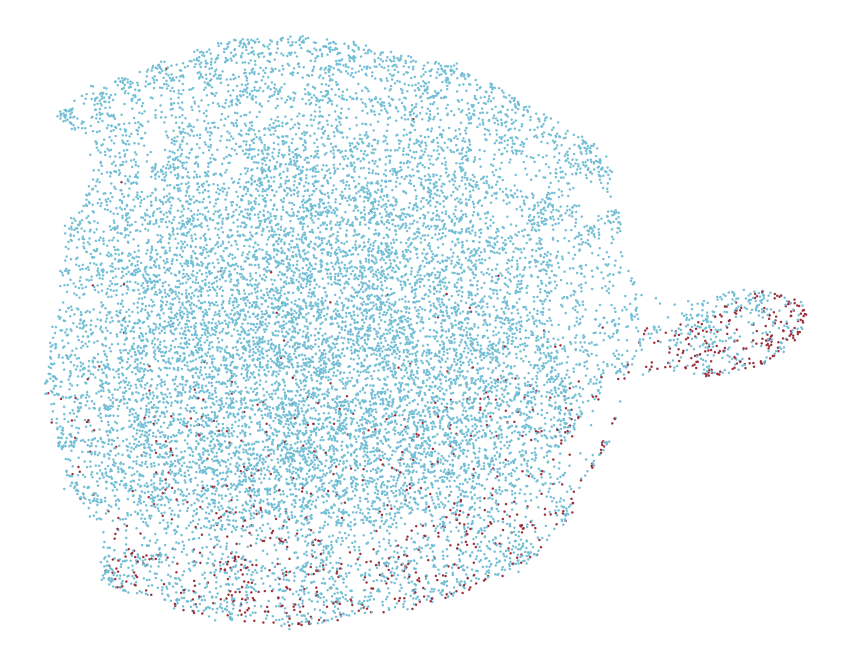

In [23]:
umap = UMAP(n_components=2, 
            n_neighbors=50, 
            min_dist=1,
            random_state=seed)
results=umap.fit_transform(df.drop('stroke', axis=1))

plt.figure(figsize=(15, 12))
a = sns.scatterplot(x=results[:,0],
                    y=results[:,1],
                    hue=df['stroke'],
                    s=6,
                    edgecolor='none',
                    palette=['#72bfd6', '#9c2f3b'])
plt.xticks([])
plt.yticks([])

for s in ['right', 'left', 'top', 'bottom']:
    a.spines[s].set_visible(False)
a.legend().set_visible(False)

plt.show()

In [24]:
def f_importance_plot(f_imp):
    f_imp['avg_imp'] = f_imp[f_imp.columns[1:]].mean(axis=1)
    f_imp.sort_values('avg_imp', ascending=False, inplace=True)
    fig = plt.figure(figsize = (15, 0.35*len(f_imp)))
    plt.title('Feature importances', size=25, y=1.05, 
              fontname='Calibri', fontweight='bold', color='#444444')
    a = sns.barplot(data=f_imp, x='avg_imp', y='feature', 
                    palette='Blues_d', linestyle="-", 
                    linewidth=1, edgecolor="black")
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11, color='#444444')
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.show()
    
def norm_0to1(preds):
    return (preds - np.min(preds)) / (np.max(preds) - np.min(preds))

def preds_plot(preds):
    plt.figure(figsize=(15, 7))
    plt.title('Distribution of predictions', 
          size=25, y=1.03, fontname='Calibri', 
          fontweight='bold', color='#444444')
    a = sns.histplot(preds, color='#72bfd6', bins=100)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname='Calibri', size=12)
    plt.yticks([])
    for s in ['right', 'top', 'left']:
        a.spines[s].set_visible(False)
    plt.show()

In [25]:
train_cb = train.copy()
train_cb.drop(train_cb[(train_cb['age']<31)&
                       (train_cb['stroke']==1)].index, inplace=True) # 4 patients

train_cb.drop(train_cb[(train_cb['age']>70)&
                       (train_cb['avg_glucose_level']>200)&
                       (train_cb['hypertension']==1)&
                       (train_cb['heart_disease']==1)&
                       (train_cb['ever_married']=='Yes')&
                       (train_cb['stroke']==0)].index, inplace=True) # 4 patients

train = pd.get_dummies(train)
train_cb = pd.get_dummies(train_cb)
test = pd.get_dummies(test)

X_cb = train_cb.drop('stroke', axis=1)
y_cb = train_cb['stroke']
    
X = train.drop('stroke', axis=1)
y = train['stroke']

seed = 228
FOLDS = 10

- FOLD 1 AUC: 0.8911 -
- FOLD 2 AUC: 0.8735 -
- FOLD 3 AUC: 0.9062 -
- FOLD 4 AUC: 0.8918 -
- FOLD 5 AUC: 0.9088 -
- FOLD 6 AUC: 0.8866 -
- FOLD 7 AUC: 0.9051 -
- FOLD 8 AUC: 0.9046 -
- FOLD 9 AUC: 0.9187 -
- FOLD 10 AUC: 0.9096 -
*********************************************
Mean AUC: 0.8996


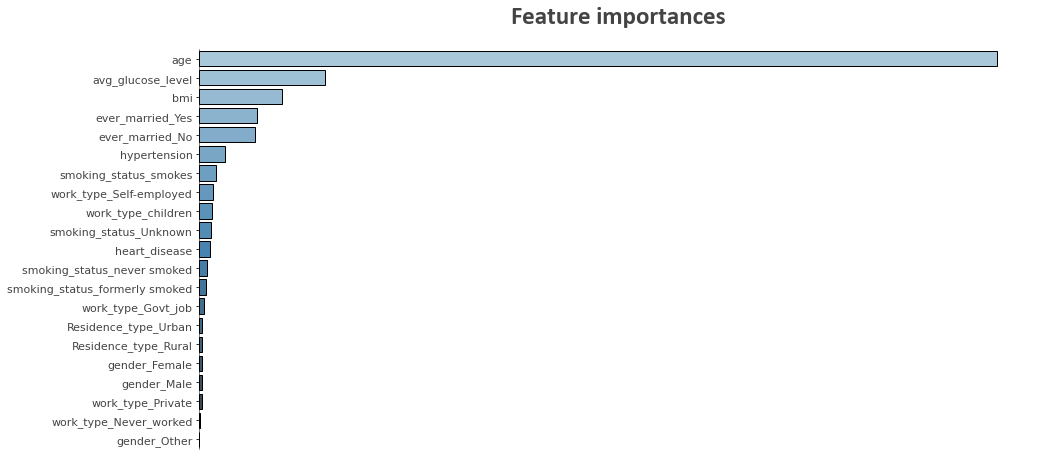

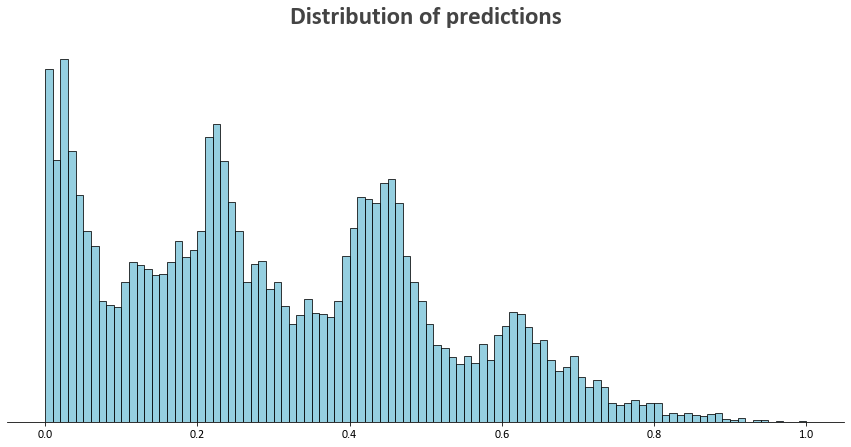

In [26]:
cb_params = {
    'depth': 3,
    'learning_rate': 0.01,
    'rsm': 0.5,
    'subsample': 0.931,
    'l2_leaf_reg': 69,
    'min_data_in_leaf': 20,
    'random_strength': 0.175,
    
    'random_seed': seed,
    'use_best_model': True,
    'task_type': 'CPU',
    'bootstrap_type': 'Bernoulli',
    'grow_policy': 'SymmetricTree',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC'
}

f_imp = pd.DataFrame({'feature': X.columns})
predictions, scores = np.zeros(len(test)), []

k = StratifiedKFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X_cb, y_cb)):    
    cb_train = cb.Pool(data=X_cb.iloc[train_idx],
                       label=y_cb.iloc[train_idx])
    cb_valid = cb.Pool(data=X_cb.iloc[val_idx],
                       label=y_cb.iloc[val_idx])
    
    model = cb.train(params=cb_params,
                     dtrain=cb_train,
                     num_boost_round=10000,
                     evals=cb_valid, 
                     early_stopping_rounds=500,
                     verbose=False)
    
    f_imp['fold_'+str(fold+1)] = model.get_feature_importance()
    val_preds = model.predict(cb_valid)
    val_score = roc_auc_score(y_cb.iloc[val_idx], val_preds)
    scores.append(val_score)
    
    predictions += model.predict(test) / FOLDS
    print(f'- FOLD {fold+1} AUC: {round(val_score, 4)} -')
    
    del cb_train, cb_valid, val_preds, val_score, model
    gc.collect()

print('*'*45)
print(f'Mean AUC: {bold[0]}{round(np.mean(scores), 4)}{bold[1]}')

predictions = norm_0to1(predictions)
cb_preds = predictions.copy()
f_importance_plot(f_imp)
preds_plot(predictions)

In [28]:
sc = StandardScaler()
X[num_cols] = sc.fit_transform(X[num_cols])
test[num_cols] = sc.transform(test[num_cols])

X = X.values
y = y.values
test = test.values

319/319 [==============================] - 0s 1ms/step
- FOLD 1 AUC: 0.8829 -
319/319 [==============================] - 1s 2ms/step
- FOLD 2 AUC: 0.9093 -
319/319 [==============================] - 1s 2ms/step
- FOLD 3 AUC: 0.9054 -
319/319 [==============================] - 0s 1ms/step
- FOLD 4 AUC: 0.888 -
319/319 [==============================] - 0s 1ms/step
- FOLD 5 AUC: 0.8757 -
319/319 [==============================] - 0s 1ms/step
- FOLD 6 AUC: 0.8777 -
319/319 [==============================] - 0s 1ms/step
- FOLD 7 AUC: 0.8929 -
319/319 [==============================] - 1s 2ms/step
- FOLD 8 AUC: 0.9036 -
319/319 [==============================] - 1s 2ms/step
- FOLD 9 AUC: 0.8757 -
319/319 [==============================] - 0s 1ms/step
- FOLD 10 AUC: 0.884 -
Mean AUC: 0.8895


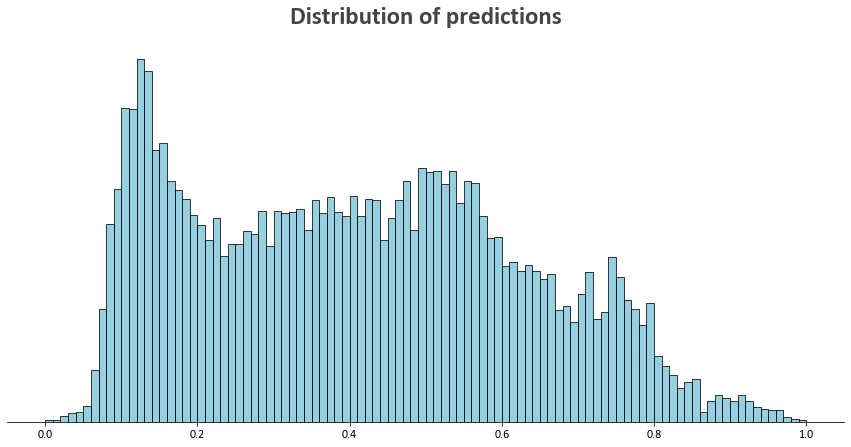

In [36]:
VERBOSE = False
BATCH_SIZE = 32
predictions, scores = [], []

lr = ReduceLROnPlateau(monitor='val_auc', factor=0.7, 
                       patience=5, verbose=VERBOSE)

es = EarlyStopping(monitor='val_auc', patience=15, 
                   verbose=VERBOSE, mode='max', 
                   restore_best_weights=True)

k = StratifiedKFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
        
    model = my_model()
    model.compile(optimizer='adam', 
                  loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.1, gamma=3),
                  metrics='AUC')
        
    model.fit(X_train, y_train, 
              validation_data=(X_val, y_val), 
              epochs=300,
              verbose=VERBOSE,
              batch_size=BATCH_SIZE, 
              class_weight={0: 1, 1: 10},
              callbacks=[lr, es])
        
    y_pred = norm_0to1(model.predict(X_val))
    val_score = roc_auc_score(y_val, y_pred)
    scores.append(val_score)
    
    predictions.append(model.predict(test))
    print(f'- FOLD {fold+1} AUC: {round(val_score, 4)} -')
    
print(f'Mean AUC: {bold[0]}{round(np.mean(scores), 4)}{bold[1]}')
predictions = norm_0to1(np.squeeze(np.mean(predictions, axis=0)))
nn_preds = predictions.copy()
preds_plot(predictions)

In [ ]:
ss['stroke'] = (cb_preds*0.7 + nn_preds*0.3)*0.4 + lasso_preds*0.6 
ss.to_csv('submission_.csv', index=False)
preds_plot(ss['stroke'])